In [1]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
from collections import deque 
from tqdm import tqdm
import time

C:\Users\Nikhil\anaconda3\envs\myenv\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
env_info =      """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -2.4                    2.4
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.209 rad (-12 deg)    0.209 rad (12 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """
print(env_info)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -2.4                    2.4
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.209 rad (-12 deg)    0.209 rad (12 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or 

creating the environment

In [3]:
env = gym.make("CartPole-v1")
env.reset()
env.render()

True

In [4]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 2_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 500  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 32  # How many steps (samples) to use for training
TAU = 0.1
# Environment settings
EPISODES = 2000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.01

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes

In [5]:
def make_model(obs_space, act_space):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape = obs_space),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(act_space, activation="linear")
    ])
    
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
    
    return model

In [6]:
# initialize replay memory to capacity 
replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE) 

# initialize action-value function 
model = make_model((1,4), 2)

# initialize target action-value function
target_model = make_model(env.observation_space.shape, env.action_space.n)
target_model.set_weights(model.get_weights())

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 64)             320       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 2)              130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Queries action-value function network for Q values given current observation space (environment state)
def get_qs(state):
    return model.predict(state.reshape(-1,1,4))

In [9]:
# Trains main network (action-value function) every step during episode
def train(terminal_state):
    
    # Start training only if certain number of samples is already saved
    if len(replay_memory) < MIN_REPLAY_MEMORY_SIZE:
        return

    # Get a minibatch of random samples from memory replay table
    minibatch = random.sample(replay_memory, MINIBATCH_SIZE)

    # Get current states from minibatch, then query NN model for Q values
    current_states = np.array([transition[0] for transition in minibatch])
    current_qs_list = model.predict(current_states)

    # Get future states from minibatch, then query NN model for Q values
    new_current_states = np.array([transition[3] for transition in minibatch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    y = []

    # Now we need to enumerate our batches
    for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

    # If not a terminal state, get new q from future states, otherwise set it to 0
    # almost like with Q Learning, but we use just part of equation here
        if not done:
            max_future_q = np.max(future_qs_list[index])
            new_q = reward + DISCOUNT * max_future_q
        else:
            new_q = reward

        # Update Q value for given state
        current_qs = current_qs_list[index]
        current_qs[0][action] = new_q

        # And append to our training data
        X.append(current_state)
        y.append(current_qs)

    # Fit on all samples as one batch, log only on terminal state
    if terminal_state:
        model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)
        
        q_network_theta = model.get_weights()
        target_network_theta = target_model.get_weights()
        counter = 0
        for q_weight, target_weight in zip(q_network_theta,target_network_theta):
            target_weight = target_weight * (1-TAU) + q_weight * TAU
            target_network_theta[counter] = target_weight
            counter += 1
        target_model.set_weights(target_network_theta)
    # Update target network counter every episode
   

In [10]:
MIN_REWARD = 50  # For model save
AGGREGATE_STATS_EVERY = 50  # episodes

In [11]:
rewards = []

for episode in tqdm(range(1, EPISODES+1), ascii=True, unit='episodes'):
    state = env.reset().reshape(1,-1)
    done = False
    total_rewards = 0
    step = 1
    
    while not done:
        # Choose A from S using policy derived from Q (e.g., "epsilon-greedy)
        exp_exp_tradeoff = random.uniform(0,1)
        
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(get_qs(state))
        else:
            action = env.action_space.sample()
        
        # Take action A, observe R, new_state
        new_state, reward, done, info = env.step(action)
        new_state = new_state.reshape(1,-1)
                
        total_rewards += reward
        
        env.render()
        
        replay_memory.append((state, action, reward, new_state, done))
        train(done)
        
        # S = new_state
        state = new_state
        step += 1


    # Reduce epsilon (because we need less and less exploration)
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
        
    rewards.append(total_rewards)
    
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(rewards[-AGGREGATE_STATS_EVERY:])/len(rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(rewards[-AGGREGATE_STATS_EVERY:])
        print(f"{episode} done, average reward = {average_reward}, min={min_reward}, max={max_reward}")
        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            model.save(f'cart__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}')

env.close()

  0%|                                                                                  | 1/2000 [00:00<08:28,  3.93episodes/s]

1 done, average reward = 15.0, min=15.0, max=15.0


  1%|7                                                                                | 18/2000 [00:11<18:54,  1.75episodes/s]

  2%|##                                                                               | 50/2000 [01:28<55:32,  1.71s/episodes]

50 done, average reward = 22.92, min=9.0, max=101.0


  5%|####                                                                            | 100/2000 [03:02<46:33,  1.47s/episodes]

100 done, average reward = 13.74, min=8.0, max=32.0


  8%|######                                                                          | 150/2000 [04:28<50:14,  1.63s/episodes]

150 done, average reward = 11.1, min=8.0, max=21.0


 10%|########                                                                        | 200/2000 [05:50<52:12,  1.74s/episodes]

200 done, average reward = 10.58, min=8.0, max=14.0


 12%|##########                                                                      | 250/2000 [07:26<57:41,  1.98s/episodes]

250 done, average reward = 12.3, min=8.0, max=16.0


 15%|###########7                                                                  | 300/2000 [09:34<1:17:42,  2.74s/episodes]

300 done, average reward = 16.12, min=9.0, max=33.0


 18%|#############6                                                                | 350/2000 [25:30<7:09:46, 15.63s/episodes]

350 done, average reward = 96.0, min=10.0, max=500.0


 20%|###############6                                                              | 400/2000 [44:12<1:46:23,  3.99s/episodes]

400 done, average reward = 127.3, min=13.0, max=500.0


 22%|##################                                                              | 450/2000 [53:16<58:37,  2.27s/episodes]

450 done, average reward = 67.28, min=9.0, max=405.0


 25%|###################                                                         | 500/2000 [1:05:02<3:07:04,  7.48s/episodes]

500 done, average reward = 86.72, min=9.0, max=300.0


 28%|####################9                                                       | 550/2000 [1:10:44<1:20:34,  3.33s/episodes]

550 done, average reward = 42.68, min=11.0, max=175.0


 30%|#######################4                                                      | 600/2000 [1:14:30<38:05,  1.63s/episodes]

600 done, average reward = 27.8, min=8.0, max=209.0


 32%|#########################3                                                    | 650/2000 [1:16:55<35:59,  1.60s/episodes]

650 done, average reward = 17.48, min=8.0, max=335.0


 35%|##########################6                                                 | 700/2000 [1:20:41<1:51:57,  5.17s/episodes]

700 done, average reward = 27.26, min=8.0, max=156.0


 38%|############################5                                               | 750/2000 [1:24:18<1:34:21,  4.53s/episodes]

750 done, average reward = 26.16, min=12.0, max=103.0


 40%|##############################4                                             | 800/2000 [1:33:53<3:13:17,  9.66s/episodes]

800 done, average reward = 70.4, min=25.0, max=155.0


 42%|################################3                                           | 850/2000 [1:40:39<5:05:40, 15.95s/episodes]

850 done, average reward = 49.92, min=18.0, max=245.0


 45%|##################################2                                         | 900/2000 [1:47:12<2:38:24,  8.64s/episodes]

900 done, average reward = 47.5, min=15.0, max=130.0


 48%|####################################1                                       | 950/2000 [1:55:30<2:12:08,  7.55s/episodes]

950 done, average reward = 47.94, min=18.0, max=176.0


 50%|#####################################5                                     | 1000/2000 [2:04:31<4:56:32, 17.79s/episodes]

1000 done, average reward = 49.32, min=15.0, max=185.0


 52%|#######################################3                                   | 1050/2000 [2:09:52<1:33:13,  5.89s/episodes]

1050 done, average reward = 37.46, min=17.0, max=247.0


 55%|#########################################2                                 | 1100/2000 [2:27:25<5:38:18, 22.55s/episodes]

1100 done, average reward = 137.24, min=25.0, max=500.0


 57%|###########################################1                               | 1150/2000 [2:50:19<5:30:22, 23.32s/episodes]

1150 done, average reward = 182.5, min=39.0, max=500.0


 60%|#############################################                              | 1200/2000 [3:20:11<3:09:19, 14.20s/episodes]

1200 done, average reward = 238.7, min=23.0, max=500.0


 62%|##############################################8                            | 1249/2000 [3:47:49<7:09:07, 34.28s/episodes]

1250 done, average reward = 227.94, min=102.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__227.94avg__102.00min__1640460630\assets


 65%|################################################7                          | 1299/2000 [4:32:21<9:58:07, 51.20s/episodes]

1300 done, average reward = 362.74, min=212.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__362.74avg__212.00min__1640463328\assets


 67%|#################################################9                        | 1349/2000 [5:15:26<11:44:08, 64.90s/episodes]

1350 done, average reward = 343.82, min=197.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__343.82avg__197.00min__1640465890\assets


 70%|###################################################7                      | 1399/2000 [6:03:19<10:31:40, 63.06s/episodes]

1400 done, average reward = 389.78, min=212.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__389.78avg__212.00min__1640468786\assets


 72%|######################################################3                    | 1450/2000 [6:40:26<9:47:06, 64.05s/episodes]

1450 done, average reward = 289.04, min=20.0, max=500.0


 75%|#######################################################4                  | 1499/2000 [7:36:01<10:24:24, 74.78s/episodes]

1500 done, average reward = 458.02, min=279.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__458.02avg__279.00min__1640474347\assets


 77%|##########################################################                 | 1549/2000 [8:26:46<7:01:01, 56.01s/episodes]

1550 done, average reward = 409.56, min=114.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__409.56avg__114.00min__1640477393\assets


 80%|############################################################               | 1600/2000 [8:41:18<1:13:23, 11.01s/episodes]

1600 done, average reward = 106.74, min=8.0, max=500.0


 82%|###############################################################5             | 1650/2000 [8:47:02<18:06,  3.10s/episodes]

1650 done, average reward = 45.98, min=12.0, max=218.0


 85%|###############################################################7           | 1700/2000 [8:56:54<1:18:33, 15.71s/episodes]

1700 done, average reward = 79.46, min=12.0, max=292.0


 88%|#################################################################6         | 1750/2000 [9:20:09<1:04:31, 15.48s/episodes]

1750 done, average reward = 187.86, min=37.0, max=500.0


 90%|###################################################################4       | 1799/2000 [9:48:33<1:56:47, 34.86s/episodes]

1800 done, average reward = 231.92, min=97.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__231.92avg___97.00min__1640482245\assets


 92%|######################################################################2     | 1849/2000 [10:13:37<41:00, 16.30s/episodes]

1850 done, average reward = 202.14, min=94.0, max=500.0
INFO:tensorflow:Assets written to: cart___500.00max__202.14avg___94.00min__1640483745\assets


 95%|########################################################################2   | 1900/2000 [10:28:50<12:15,  7.35s/episodes]

1900 done, average reward = 120.8, min=30.0, max=500.0


 98%|##########################################################################1 | 1950/2000 [10:50:04<38:55, 46.71s/episodes]

1950 done, average reward = 171.76, min=26.0, max=500.0


100%|############################################################################| 2000/2000 [11:17:17<00:00, 20.32s/episodes]

2000 done, average reward = 220.2, min=30.0, max=500.0


In [12]:
env.close()

Text(0, 0.5, 'reward')

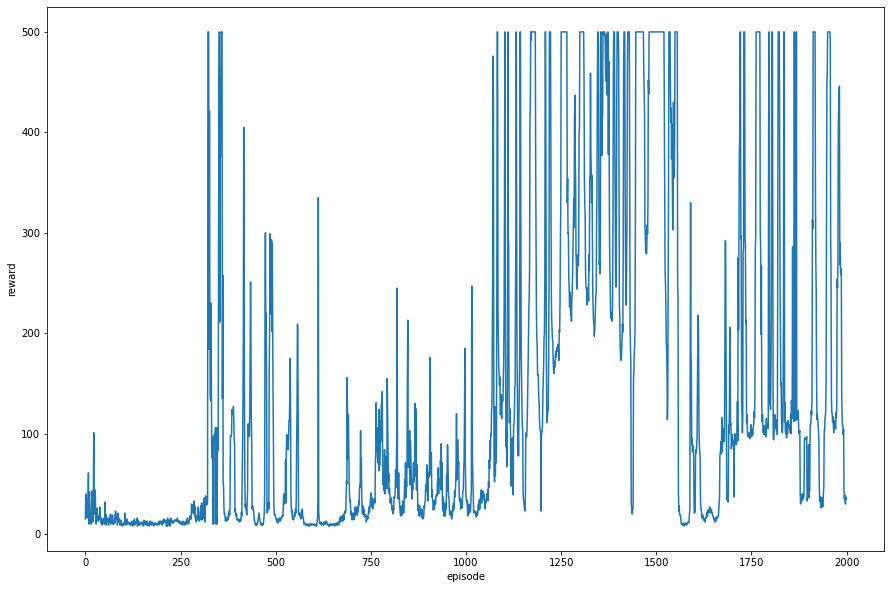

In [13]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(range(EPISODES), rewards)
ax.set_xlabel("episode")
ax.set_ylabel("reward")

Text(0, 0.5, 'reward')

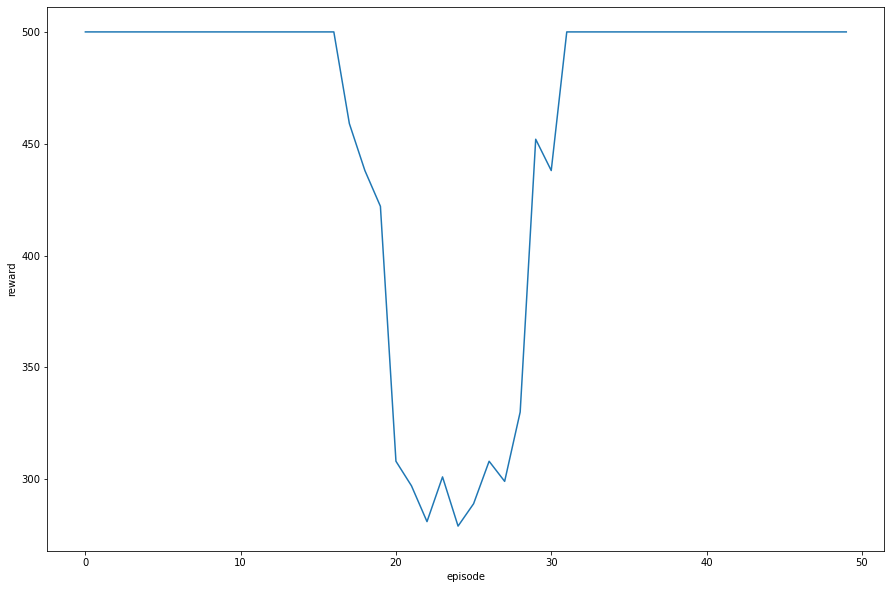

In [18]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(range(50), rewards[1450:1500] )
ax.set_xlabel("episode")
ax.set_ylabel("reward")